# Project 4 - Reinforcement Learning
### Deadline - December 5, 11.59pm

Welcome to your last assignment for CSE4/574 course! For this assignment you will implement a reinforcement learing algorithm - DQN, that will train the agent to play a game.

All the code deliverables has to be provided within this notebook.

## 1 - Packages

Let's first import all the packages that you will need during this assignment.

-  [random](https://docs.python.org/3/library/random.html) - generates pseudo-random numbers
-  [math](https://docs.python.org/3/library/math.html?highlight=math#module-math) - provides access to the a big variety of mathematical functions
-  [time](https://docs.python.org/3/library/time.html?highlight=time#module-time) - will be used to track how much time each computation takes
- [numpy](http://www.numpy.org/) -  is the main package for scientific computing with Python
- [keras](https://keras.io/) -  is a high-level neural networks API, we will use to biuild a neural network for our agent
- [matplotlib](https://matplotlib.org/) - is a plotting library
- [IPython](https://ipython.org/) - is an interactive shell, that will help us to display our framework

In [1]:
#######################################################################
# Authors:                                                            #
# Nathan Margaglio (nathanmargaglio@gmail.com)                        #
# Alina Vereshchaka (avereshc@buffalo.edu)                            #
#######################################################################

import random, math, time
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline

try:
  from google.colab import files
except:
  print("Could not import Google Colab.")

Using TensorFlow backend.


Could not import Google Colab.


## 2 - Environment
Here we define our grid-world environment.
No need to make any changes!

In [2]:
class Environment:

  def __init__(self, grid_size):
      self.grid_size = grid_size
      
      self.cat = imread('https://image.ibb.co/btGeAA/tom.png')
      self.mouse = imread('https://image.ibb.co/njNNxq/jerry.png')
      self.confetti = imread('https://image.ibb.co/ganuAA/tom-and-jerry.png')
      self.dim = 1.5
      
      self.rewards = []
      
  def _update_state(self, action):
      state = self.state
      # 0 = left
      # 1 = right
      # 2 = down
      # 3 = up

      fy, fx, py, px = state
      old_d = abs(fx - px) + abs(fy - py)

      if action == 0:
          if px > 0:
              px -= 1
      if action == 1:
          if px < self.grid_size-1:
              px += 1
      if action == 2:
          if py > 0:
              py-= 1
      if action == 3:
          if py < self.grid_size-1:
              py += 1

      new_d = abs(fx - px) + abs(fy - py)
      self.d = old_d-new_d
      self.time = self.time - 1
      return np.array([fy, fx, py, px])

  def _get_reward(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if fruit_x == player_x and fruit_y == player_y: return 1
    if self.d == 1: return 1
    if self.d == 0: return -1
    if self.d == -1: return -1

  def _is_over(self):
    fruit_y, fruit_x, player_y, player_x = self.state
    if self.time == 0: return True
    if fruit_x == player_x and fruit_y == player_y: return True
    return False

  def step(self, action):
    self.state = self._update_state(action)
    reward = self._get_reward()
    self.rewards.append(reward)
    game_over = self._is_over()
    return self.state, reward, game_over
  
  def render(self):
    # Note: there's no promises of efficieny with this method
    # If things are slow, remove it
    
    im_size = (self.grid_size,)*2
    state = self.state
    
    self.fig = plt.figure(figsize=(8, 6), dpi=80)
    self.ax = self.fig.add_subplot(111)
    
    self.ax.clear()
    self.ax.set_ylim((-1, self.grid_size))
    self.ax.set_xlim((-1, self.grid_size))
    #self.ax.axis('off') # uncomment to turn off axes
    self.ax.get_xaxis().set_ticks(range(self.grid_size))
    self.ax.get_yaxis().set_ticks(range(self.grid_size))
    
    xc = state[2]
    yc = state[3]
    xm = state[0]
    ym = state[1]
    
    if state[0] == state[2] and state[1] == state[3]:
      self.ax.imshow(self.confetti, 
                     extent=(-1, self.grid_size,
                             -1, self.grid_size))
    else:
      self.ax.imshow(self.mouse, 
                     extent=(xm-self.dim/4, xm+self.dim/4,
                             ym-self.dim/4, ym+self.dim/4))
      self.ax.imshow(self.cat, 
                     extent=(xc-self.dim/2, xc+self.dim/2,
                             yc-self.dim/2, yc+self.dim/2))
    self.fig.canvas.draw()
    return np.array(self.fig.canvas.renderer._renderer)

  def reset(self, deterministic=True):
    if deterministic:
      # this is an easier environment setup
      fruit_x = self.grid_size - 1
      fruit_y = self.grid_size - 1
      player_x = 0
      player_y = 0
      time = self.grid_size*2
    else:
      generated = False
      while not generated\
      or abs(fruit_x - player_x) + abs(fruit_y - player_y) < self.grid_size/2:
        fruit_x = np.random.randint(0, self.grid_size-1)
        fruit_y = np.random.randint(0, self.grid_size-1)
        player_x = np.random.randint(0, self.grid_size-1)
        player_y = np.random.randint(0, self.grid_size-1)
        time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
        time *= 2
        generated = True

    self.time = time
    self.d = 0
    self.state = np.asarray([fruit_y, fruit_x, player_y, player_x])

    return self.state

### Random actions
This runs the environment using random actions. Try to run it!

Setting up environment
Running random simulation
Resetting environment


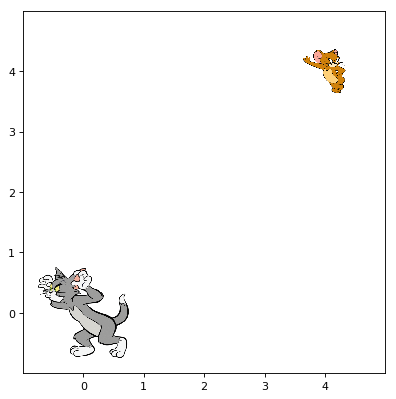

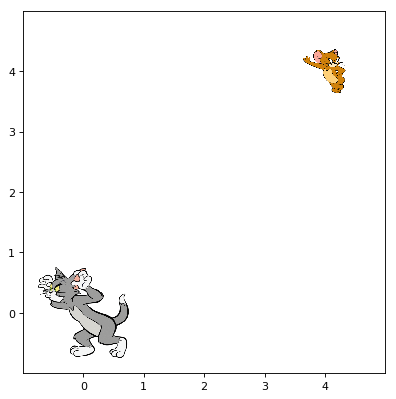

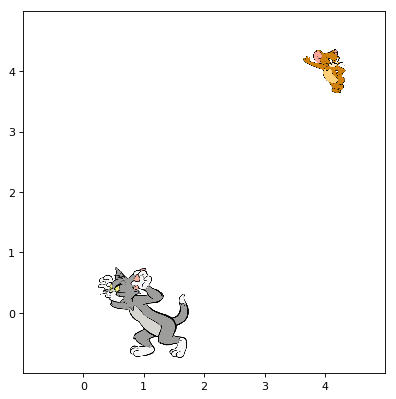

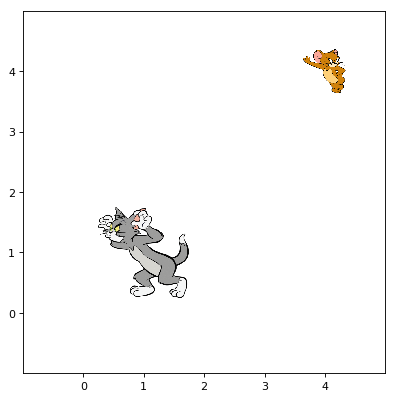

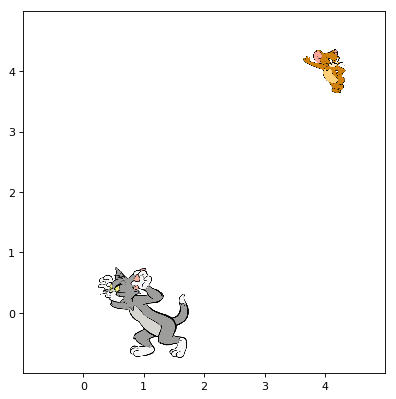

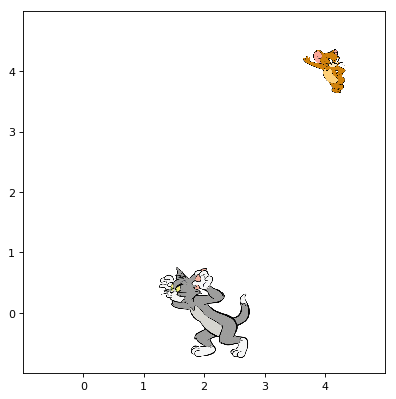

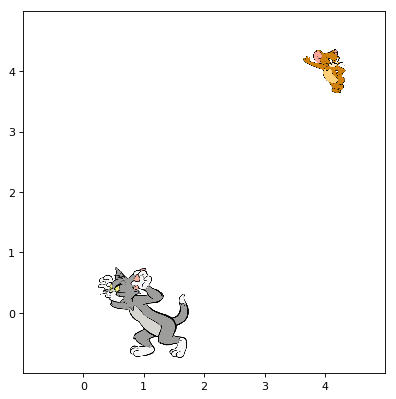

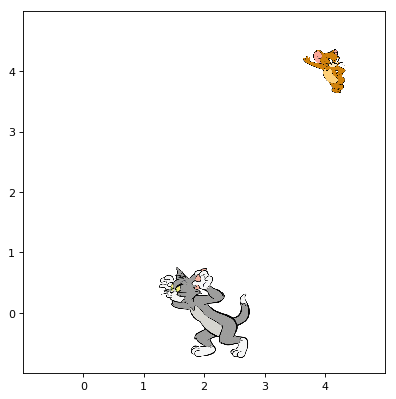

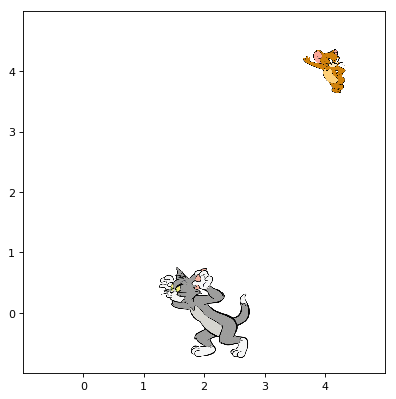

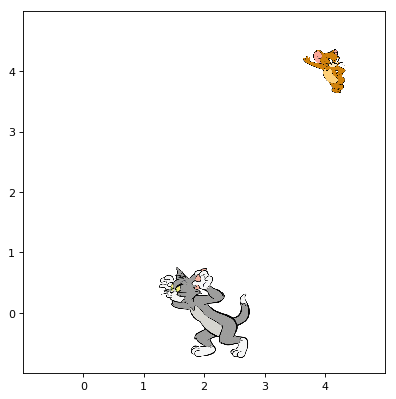

In [3]:
"""
This runs the environment using random actions
"""

print('Setting up environment')
env = Environment(5)
num_episodes = 1 # number of games we want the agent to play
env.reset()
frames = []
RENDER = True
print('Running random simulation')
for episode in range(num_episodes):
  print('Resetting environment')
  s = env.reset() # Initial state
  while True: 
    a = np.random.choice(range(4)) # choose a random action
    s_, r, done = env.step(a) # apply random action
    
    if RENDER:
      fig = env.render()
      plt.imshow(fig)
      plt.show()
      frames.append(fig)

    if done:
      break

## 3 - Brain

The 'brain' of the agent is where the model is created and held.

### Neural Network structure for our task

<img src="http://drive.google.com/uc?export=view&id=1KRXsrxZPbZh5SWq61sxVq4xiP8OYzKPN" width="60%" height="60%">

Our DQN takes a stack of six-tuple as an input. It is passed through two hidden networks, and output a vector of Q-values for each action possible in the given state. \\
** Example: **
$Q(s_t, a_1)$ - q-value for a given state $s$, if we choose action $a_1$ \\
We need to choose such an action, that will return the higest Q-value.

In the beginning, the agent does really badly. But over time, it begins to associate states with best actions to do.
 
 
###  <font color='red'>Task 1: Build a 3-layer neural network, using Keras liblary.</font>  <br>
**Instructions:**
- Build a three-layer neural network with two hidden layers
- The model's structure is: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR.
- Activation function for the first and second hidden layers is <mark>'relu'</mark>
- Activation function for the final layer is  <mark>'linear'</mark> (that returns real values)
- Input dimentions for the first hidden layer equals to the size of your observation space (<mark>state_dim</mark>)
- Number of hidden nodes is <mark>128</mark>
- Number of the output should be the same as the size of the action space (<mark>action_dim</mark>)


In [4]:
#-------------------- BRAIN ---------------------------

class Brain:
  """The 'brain' of the agent, where the model is created and held.
  
  state_dim (int): the size of the observation space
  action_dim (int): the size of the action space
  
  """
  def __init__(self, state_dim, action_dim, weights=None):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.model = self._createModel()
    if weights:
      self.model.load_weights("brain.h5")

  def _createModel(self):
    # Creates a Sequential Keras model
    # This acts as the Deep Q-Network (DQN)
    
    model = Sequential()

    ### START CODE HERE ### (≈ 3 lines of code)

    model.add(Dense(128, activation='relu', input_dim=4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='linear'))
    
    ### END CODE HERE ###

    opt = RMSprop(lr=0.00025)
    model.compile(loss='mse', optimizer=opt)

    return model

  def train(self, x, y, epoch=1, verbose=0):
    self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)

  def predict(self, s):
    return self.model.predict(s)

  def predictOne(self, s):
    return self.predict(s.reshape(1, self.state_dim)).flatten()

## 4 - Memory

In this block we are defining the main functions that will be used to store the exeriences of our agent. <br>
No need to make any modifications!

In [5]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )
  """The agent's 'memory', where experiences are stored
  """

  def __init__(self, capacity):
    self.capacity = capacity
    self.samples = []

  def add(self, sample):
    # a sample should be an array [s, a, r, s_]
    # s: current state
    # a: current action
    # r: current reward
    # s_: next state
    self.samples.append(sample)        

    if len(self.samples) > self.capacity:
        self.samples.pop(0)

  def sample(self, n):
    n = min(n, len(self.samples))
    return random.sample(self.samples, n)

## 5 - Agent

[np.amax](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.amax.html) - 
Returns the maximum of an array 

### Epsilon

Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. We want our agent to descrese the number of random action, as it goes, so we indroduce an exponential-decay epsilon, that eventually will allow our agent to explore the evironment. \\

**Exponential-decay formula for epsilon:** \\

\begin{equation}
\epsilon = \epsilon_{min} + (\epsilon_{max} - \epsilon_{min})*e^{-\lambda|S|},
\end{equation}

where $\epsilon_{min}, \epsilon_{max} \in [0, 1]$ \\
$\lambda$ - hyperparameter for epsilon \\
$|S|$ - total number of steps


###  <font color='red'>Task 2: Implement exponential-decay formula for epsilon.</font>  <br>
**Instructions:**
- On line 50 implement the formula provided above to calculate epsilon.
- Please note, that the name for all the variables should start with <mark>self</mark>, thus </br> 

epsilon $\rightarrow$ self.epsilon </br> 
min_epsilon $\rightarrow$ self.min_epsilon

###  <font color='red'>Task 3: Implement Q-function</font>  <br>
**Instructions:**
            \begin{align} \notag
            Q_t = \begin{cases} r_t, & \mbox{if episode terminates at step } t+1 \\ r_t + \gamma max_aQ(s_t, a_t; \Theta), & \mbox{otherwise} \end{cases}
            \end{align} 

In [6]:
#-------------------- AGENT ---------------------------

class Agent:
  """The agent, which learns to navigate the environment
  
  """
  
  def __init__(self, state_dim, action_dim, memory_capacity = 10000,
              batch_size = 64, gamma = 0.99, lamb = 0.001,
               max_epsilon = 1., min_epsilon = 0.01):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.batch_size = batch_size
    self.gamma = gamma # discount rate, to calculate the future discounted reward
    self.lamb = lamb
    self.max_epsilon = max_epsilon
    self.epsilon = max_epsilon
    self.min_epsilon = min_epsilon

    self.brain = Brain(state_dim, action_dim)
    self.memory = Memory(memory_capacity)
    self.steps = 0
    self.epsilons = []

  def act(self, s, verbose=False):
    """The policy of the agent:
    Here, we determine if we explore (take a random action) based on epsilon.
    If not, we have the model predict the Q-Values for the state,
    then take the action which maximizes those values.
    """
    if random.random() < self.epsilon:
      if verbose:
        print("Random Action.")
      return random.randint(0, self.action_dim-1)
    else:
      actions = self.brain.predictOne(s)
      if verbose:
        print("Actions:", actions)
      return np.argmax(actions)

  def observe(self, sample):  # in (s, a, r, s_) format
    """The agent observes an event.
    We pass a sample (state, action, reward, next state) to be stored in memory.
    We then increment the step count and adjust epsilon accordingly.
    """
    self.memory.add(sample)        

    # slowly decrease Epsilon based on our eperience
    self.steps += 1
    
    ### START CODE HERE ### (≈ 1 line of code)
    
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1 * self.lamb * self.steps)
    
    ### END CODE HERE ###
    
    self.epsilons.append(self.epsilon)

  def replay(self):
    """The agent learns based on previous experiences.
    We sample observations (state, action, reward, next state) from memory.
    We train the model based on these observations.
    """
    
    # Random sample of experiences
    batch = self.memory.sample(self.batch_size)
    batch_size = len(batch)

    # Extracting states ('current' and 'next') from samples
    no_state = np.zeros(self.state_dim)
    states = np.array([ o[0] for o in batch ])
    states_next = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])

    # Estimating Q-Values for states
    q_vals = self.brain.predict(states)
    q_vals_next = self.brain.predict(states_next)

    # Setting up training data
    x = np.zeros((batch_size, self.state_dim))
    y = np.zeros((batch_size, self.action_dim))
    
    for i in range(batch_size):
      # Observation
      obs = batch[i]
      
      # State, Action, Reward, Next State
      st = obs[0]; act = obs[1]; rew = obs[2]; st_next = obs[3]
      
      # Estimated Q-Values for Observation
      t = q_vals[i]

      ### START CODE HERE ### (≈ 4 line of code)
    
    if st_next is None or i+1 == batch_size:
        t[act] = rew
    else:
        t[act]= rew + (self.gamma * max(t))
    
    
    
      ### END CODE HERE ###

      # Set training data
    x[i] = st
    y[i] = t

    # Train
    self.brain.train(x, y)

## 6 - Running the game

### Environment
First, we initialize our environment.  The environment, loosely structured like [OpenAI's Gym Environments](https://gym.openai.com/), has three main methods: `reset`, `step` and `render`.

- When we call **reset**, we initialize the environment with a fresh episode. This allows us to effectively run through episodes (only needing to call reset at the beginning of an episode), but, more importantly, `reset()` returns the environment's initial state.

- The **step** method accepts an action as a parameter (which, for this example, is an integer in [0, 3]), processes the action, and returns the new state, the reward for performing the action, and a boolean indicating if the run is over.

- The **render** method simplay displays the state in a "human-readable" way. In this example, it renders an image of the environment as well as diagnostic data. This method is solely used for debugging purposes, and can be omitted to speed up training time.

### Agent
When we initialize the agent, we must pass both a `state_dim` and `action_dim` into it's constructor.  These values tell the agent the dimensions of the input and the output of the neural network.  The agent has three main methods: `act`, `observe`, and `replay`.

- The **act** method takes the current state as input and returns the agent's selected action.  Optionally, you can pass a boolean to it's `verbose` parameter to print the resulting Q-Values.  Within the method, we first check if we should choose a random action (in order to explore) by comparing a randomly generated number to epsilon. If the agent decides to return a random action, then it's simply a randomly selected action from the action space (in this case, an integer in [0,3]).

  If the agent doesn't choose a random action, then the state is passed to the agent's neural network (i.e., it's `Brain` object).  This results in an array of expected discounted rewards corresponding to each action (so, for example, if the resulting array is `[0.1, 2.3, 1.5, -0.7]`, then this means it expects choosing action `0` to lead to discounted rewards of `0.1`, action `1` leading to `2.3`, etc.).  Since we are greedy with our choices, we merely choose the action corresponding to the largest reward.

- The **observe** method recieves an observation tuple `(s, a, r, s_)` as input and doesn't return anything.  Here, the observation tuple contains the current state `s`, the agent's action `a` at the current state, the reward `r` recieved for taking the action at the current state, and the resulting state `s_` that occurs after taking the action at the current state.  This tuple is saved to the agent's `Memory`, which acts as a simple queue.

- The **replay** method is where any actual learning occurs.  Up to this point, we haven't trained the agent's neural network, only applied it to determine actions given states.  In order to train it, we implement **Experience Replay**, which, in short, allows the agent to not only learn from recent observations but also previous observations.  During experinece replay, we randomly sample a set of observations from the agent's `Memory`.  These observations are then constructed in a way that allows us to pass them through the neural network to train it.  

  Simply put: after we make a complete observation, we have generated a training example.  The input for the example is the state, and the output is the expected discounted reward for each action.  In this way, training works the same way it would in any classical deep learning task (except our data is generated on the fly instead of collected prior to training).

### Algorthm

The algorthm, implemented below, simply calls these methods in sequence for some given number of episodes.  At the beginning of an episode, we reset the environment, and pass it's return value, the initial state, to the agent's act method.  This returns an action, which is then passed to the environment's step method.  This returns the next state, the reward, and the boolean indicating if the episode is over.  We then save the observation tuple to the agent's memory via the agent's observe method, then run a round of training by calling the agent's replay method.  We can then render the environment.  If the episode is over, we break from this loop, otherwise we continue with the next state being passed to the agent as the (now) current state.

When the environment is set to have a 5x5 grid, the maximum reward is 8.  You'll find the training will converge to a rolling average of over 6 reward in about 10,000 episodes.  If all the code is implemented above, running the following cell unchanged should be sufficient.  In Google Colab, this takes about 15 minutes to run until completion.

Setting up environment
Setting up agent
Running simulation


C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Episode 0
Time Elapsed: 1.74s
Epsilon 0.9995026243542734
Last Episode Reward: 0
Episode Reward Rolling Mean: nan
----------


C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100
Time Elapsed: 4.71s
Epsilon 0.9513313170338957
Last Episode Reward: 0
Episode Reward Rolling Mean: 0.0
----------
Episode 200
Time Elapsed: 8.15s
Epsilon 0.9051781940891553
Last Episode Reward: 0
Episode Reward Rolling Mean: 0.26732673267326734
----------
Episode 300
Time Elapsed: 10.96s
Epsilon 0.8612759855115193
Last Episode Reward: -2
Episode Reward Rolling Mean: 0.4427860696517413
----------
Episode 400
Time Elapsed: 13.90s
Epsilon 0.8195149129119043
Last Episode Reward: 6
Episode Reward Rolling Mean: 0.5880398671096345
----------
Episode 500
Time Elapsed: 16.85s
Epsilon 0.7797905518564399
Last Episode Reward: 2
Episode Reward Rolling Mean: 0.8403990024937655
----------
Episode 600
Time Elapsed: 19.79s
Epsilon 0.7422247049906946
Last Episode Reward: 0
Episode Reward Rolling Mean: 0.936127744510978
----------
Episode 700
Time Elapsed: 23.36s
Epsilon 0.7063399623456588
Last Episode Reward: 2
Episode Reward Rolling Mean: 1.156405990016639
----------
Episode 800
Time Elapse

C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Episode 1000
Time Elapsed: 32.95s
Epsilon 0.6093737132574009
Last Episode Reward: 0
Episode Reward Rolling Mean: 1.7147613762486127
----------
Episode 1100
Time Elapsed: 35.95s
Epsilon 0.5801855803491556
Last Episode Reward: 6
Episode Reward Rolling Mean: 1.879120879120879
----------
Episode 1200
Time Elapsed: 39.54s
Epsilon 0.5524892009251992
Last Episode Reward: 2
Episode Reward Rolling Mean: 2.0481380563124434
----------
Episode 1300
Time Elapsed: 42.51s
Epsilon 0.5261264596510901
Last Episode Reward: 8
Episode Reward Rolling Mean: 2.1915070774354706
----------
Episode 1400
Time Elapsed: 45.51s
Epsilon 0.5011075496336179
Last Episode Reward: 6
Episode Reward Rolling Mean: 2.349730976172175
----------
Episode 1500
Time Elapsed: 48.54s
Epsilon 0.4773133947390933
Last Episode Reward: 6
Episode Reward Rolling Mean: 2.498929336188437
----------
Episode 1600
Time Elapsed: 51.54s
Epsilon 0.45472790177440564
Last Episode Reward: 0
Episode Reward Rolling Mean: 2.642238507661559
----------
Ep

Episode 6800
Time Elapsed: 207.81s
Epsilon 0.04916986358338112
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.093866587076556
----------
Episode 6900
Time Elapsed: 210.49s
Epsilon 0.04735314740211322
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.120570504337597
----------
Episode 7000
Time Elapsed: 214.17s
Epsilon 0.04558476448371458
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.14606578756702
----------
Episode 7100
Time Elapsed: 216.95s
Epsilon 0.04394664907474024
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.170689901442651
----------
Episode 7200
Time Elapsed: 219.62s
Epsilon 0.0423522345522453
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.195042951696944
----------
Episode 7300
Time Elapsed: 222.32s
Epsilon 0.040832049743937296
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.218441883071796
----------
Episode 7400
Time Elapsed: 224.97s
Epsilon 0.03938232888394487
Last Episode Reward: 8
Episode Reward Rolling Mean: 6.2410628681002605
---

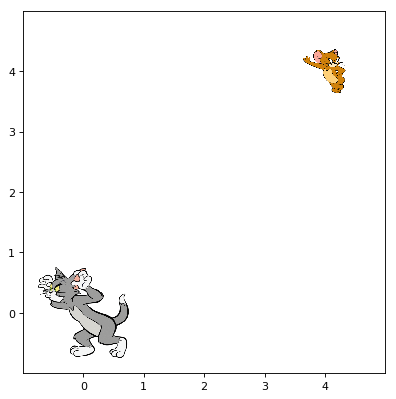

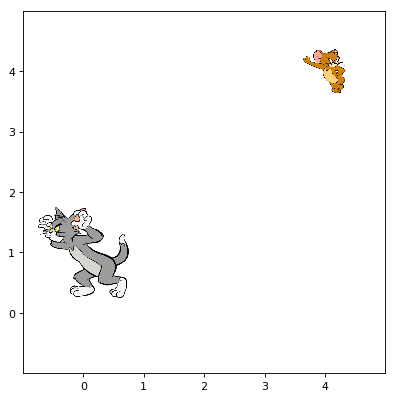

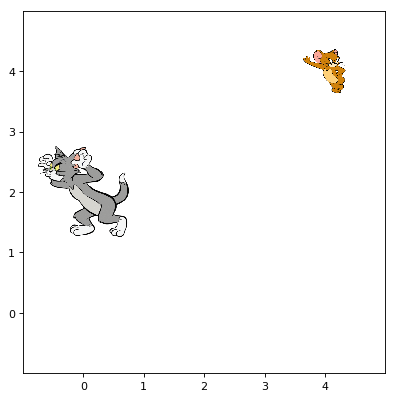

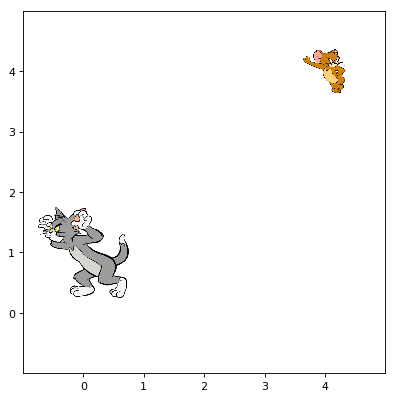

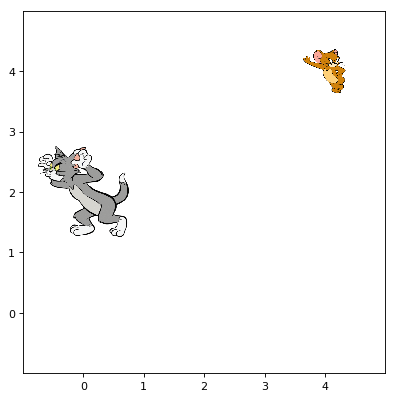

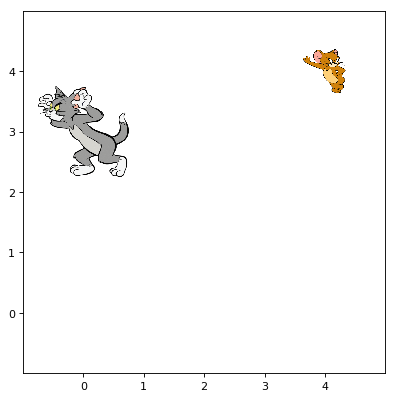

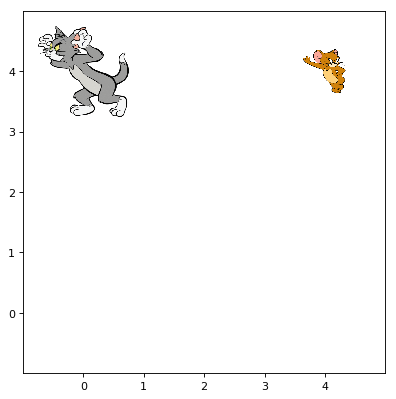

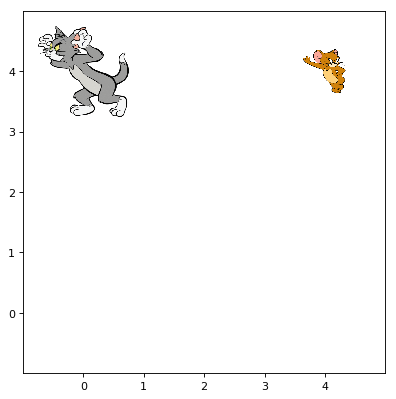

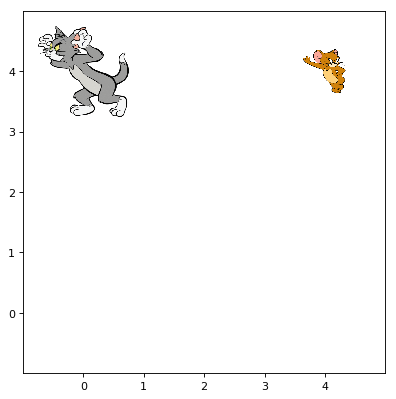

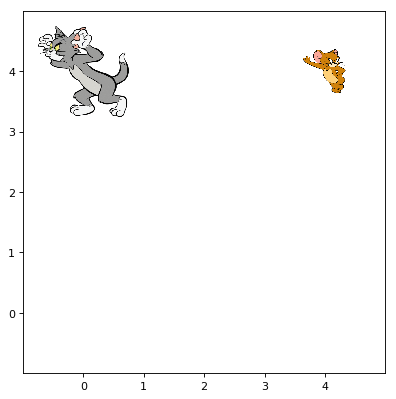

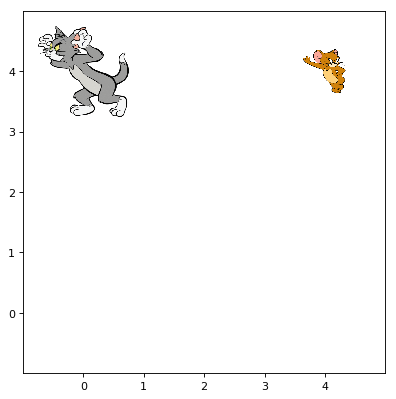

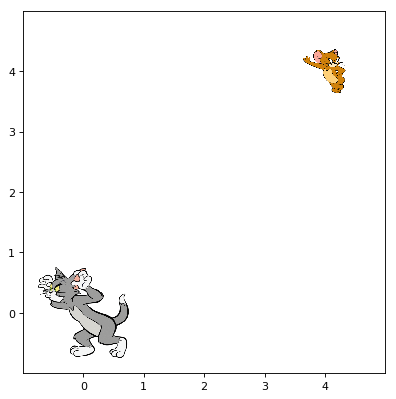

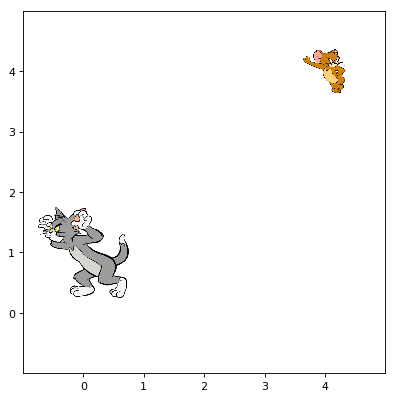

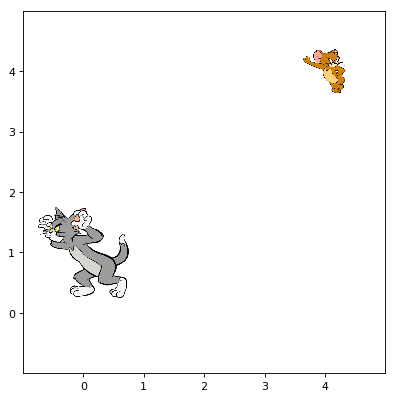

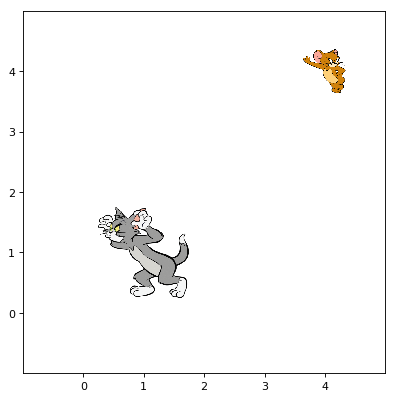

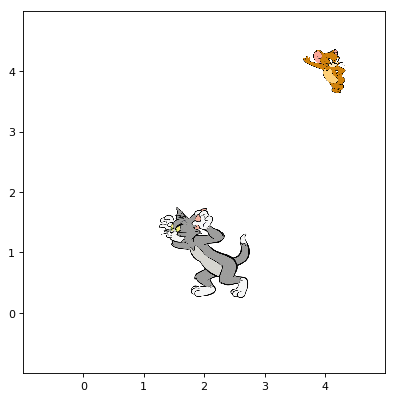

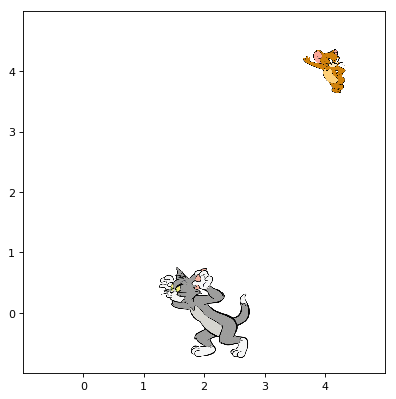

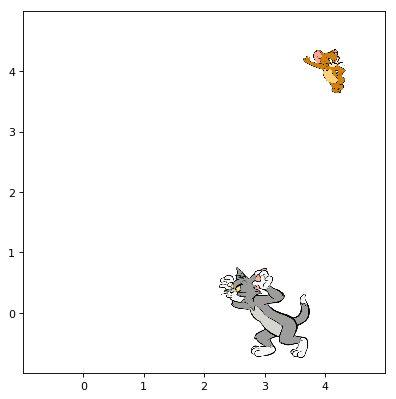

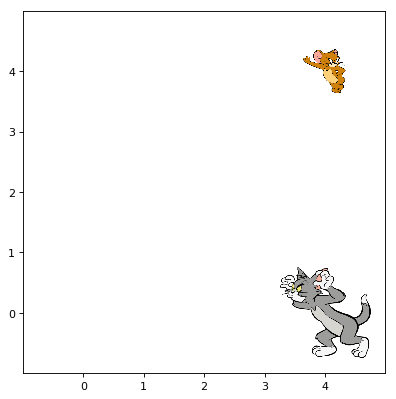

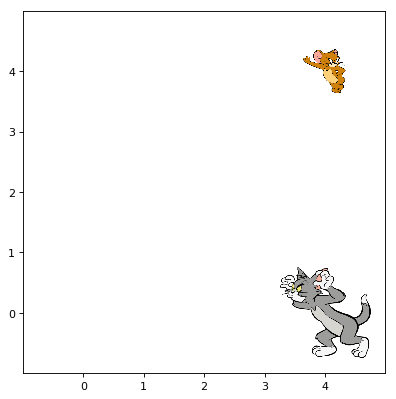

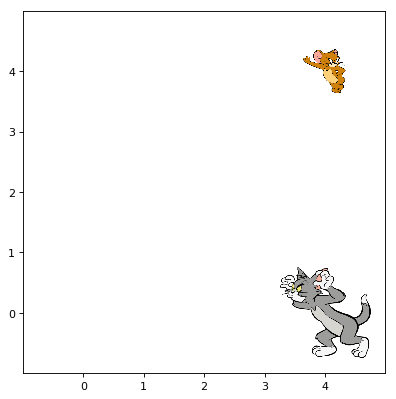

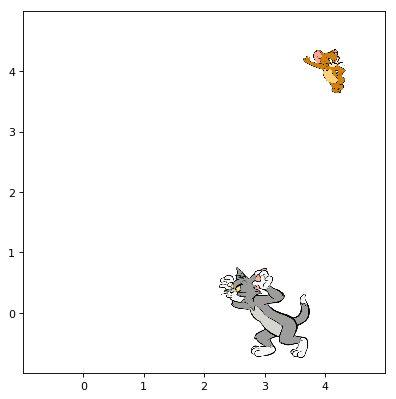

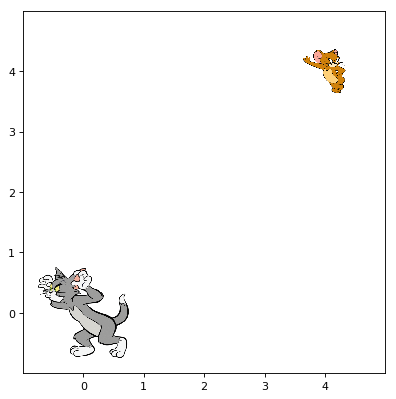

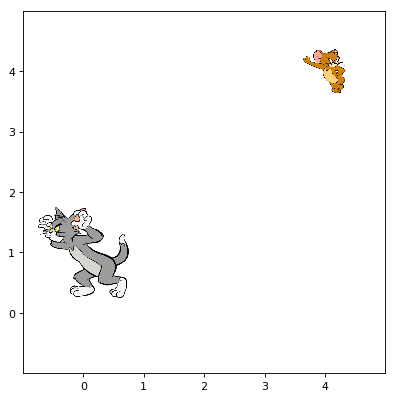

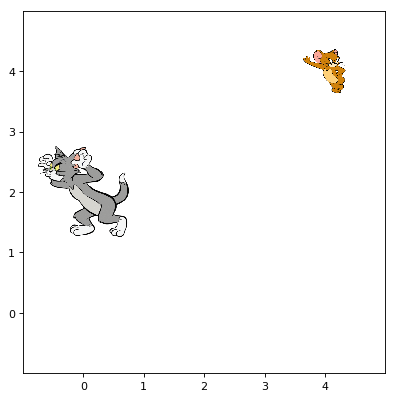

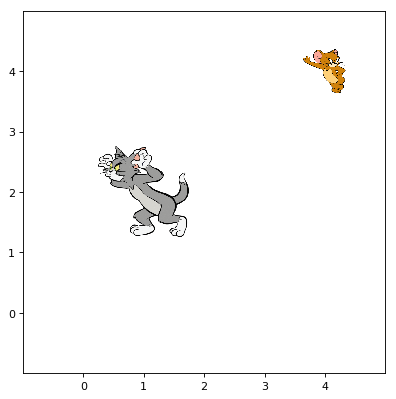

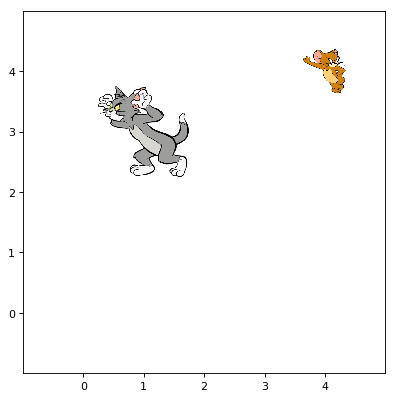

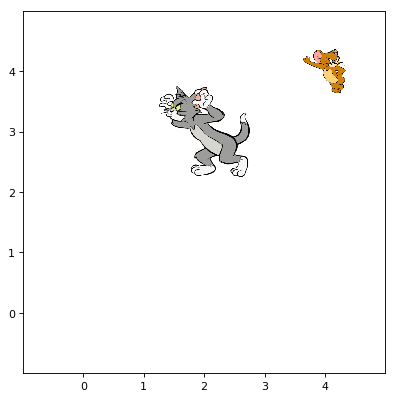

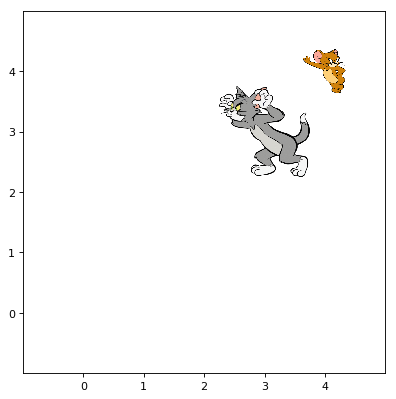

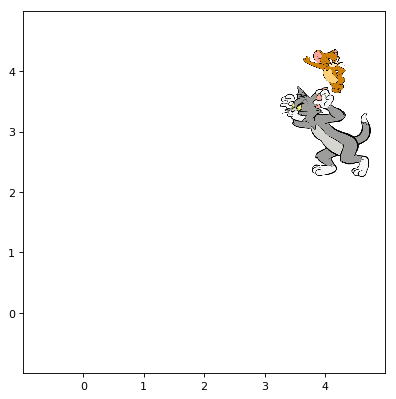

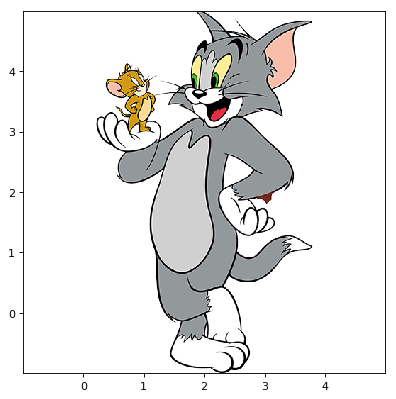

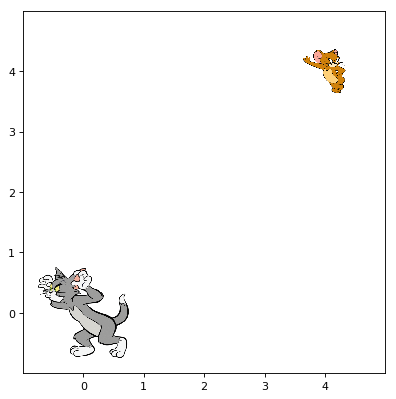

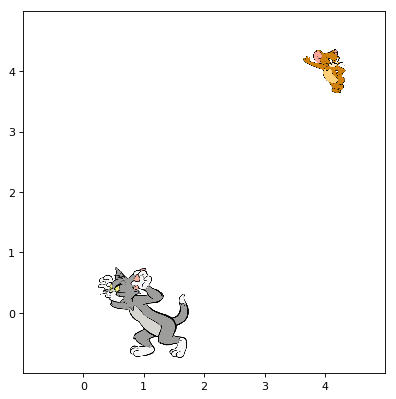

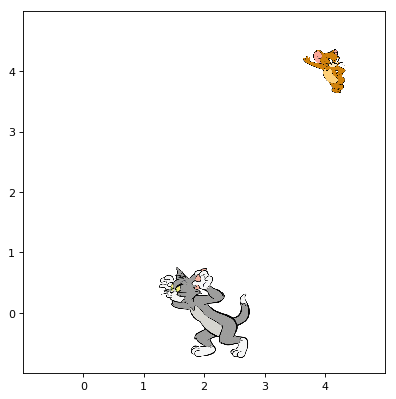

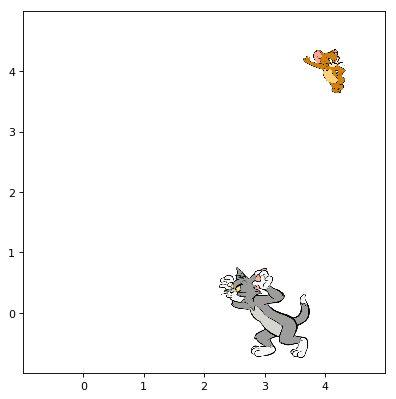

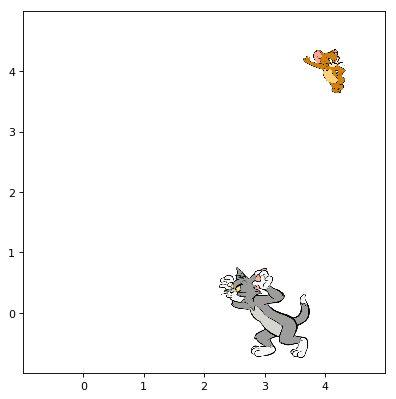

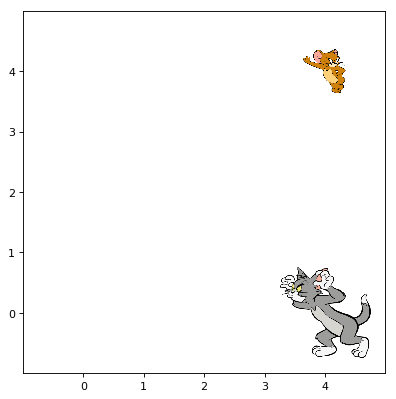

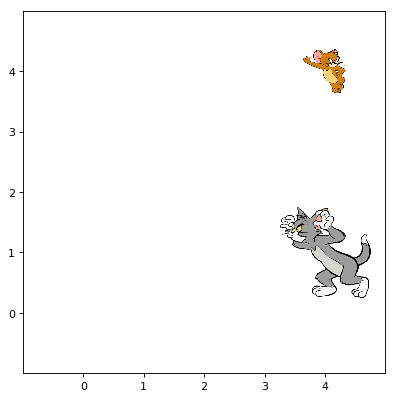

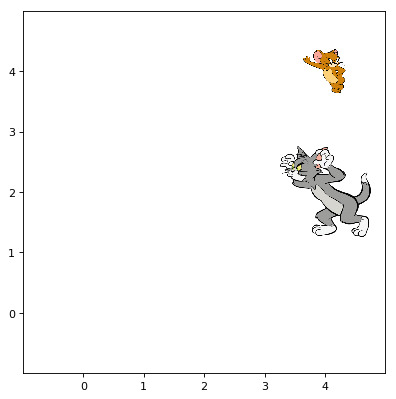

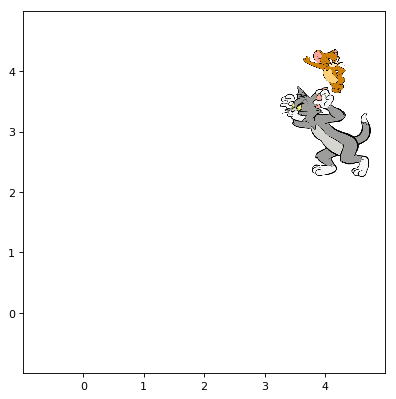

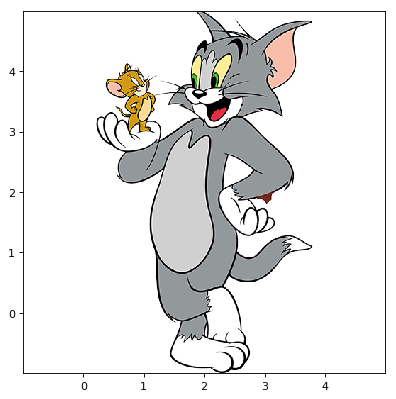

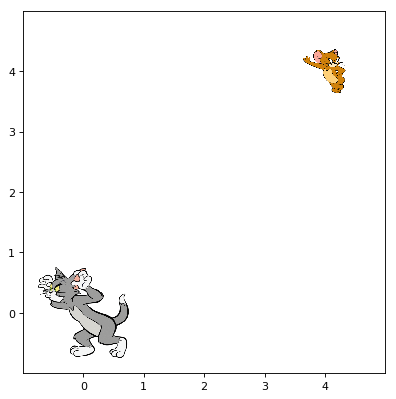

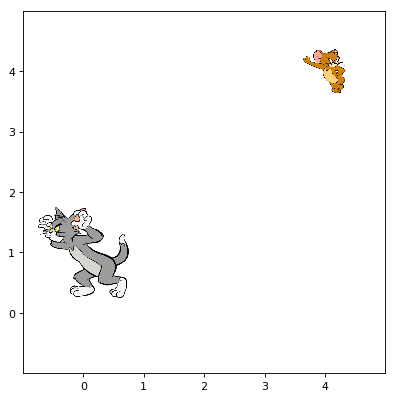

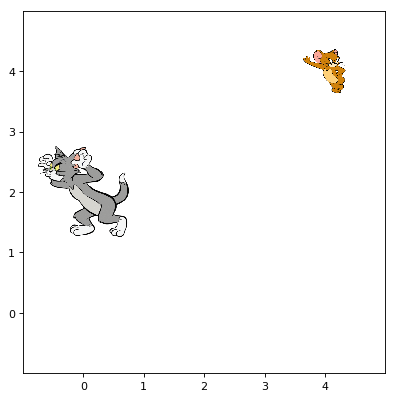

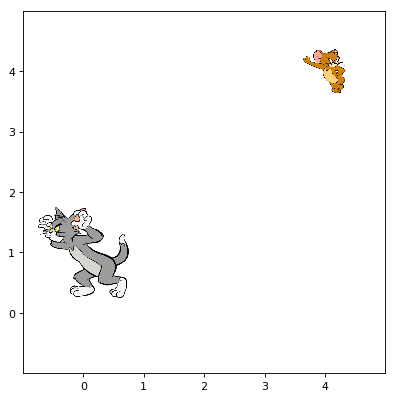

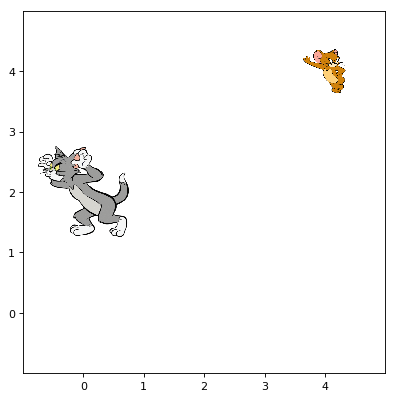

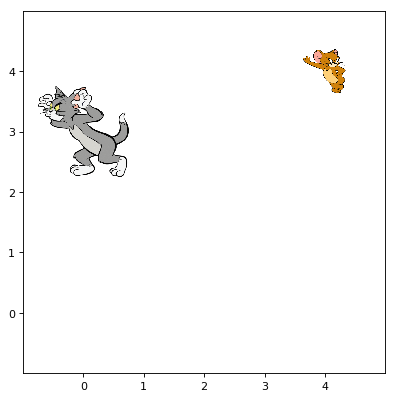

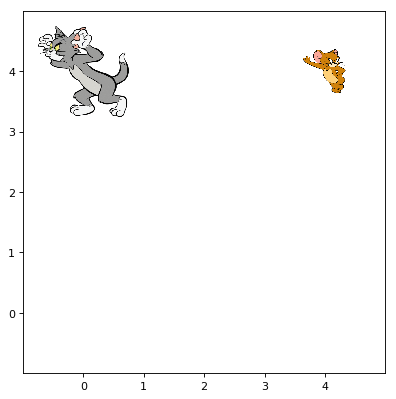

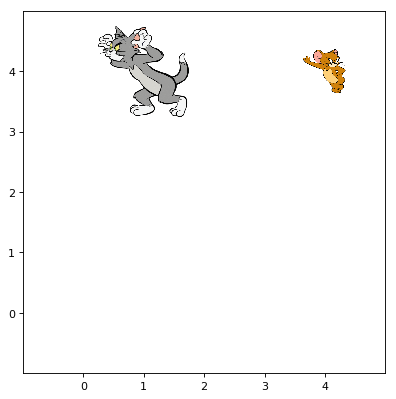

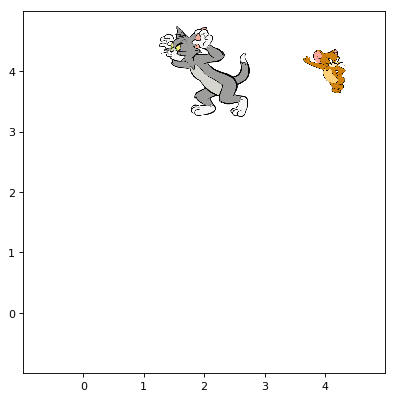

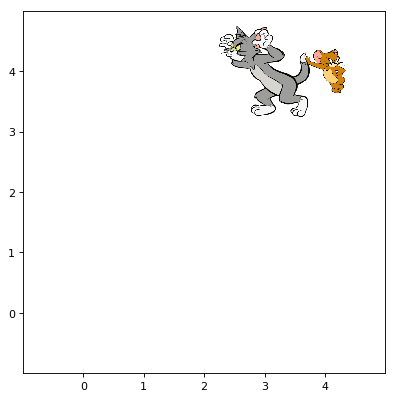

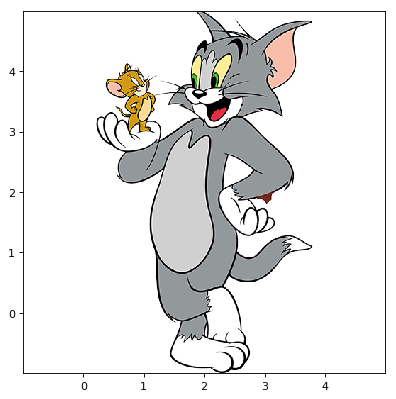

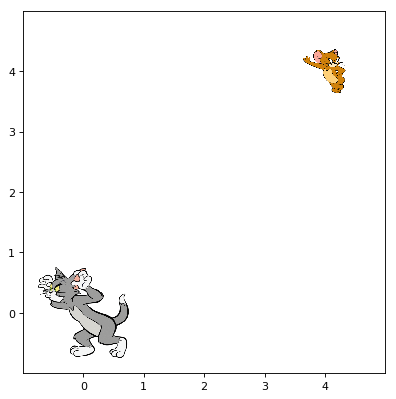

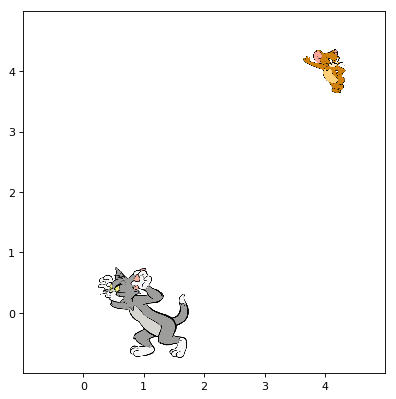

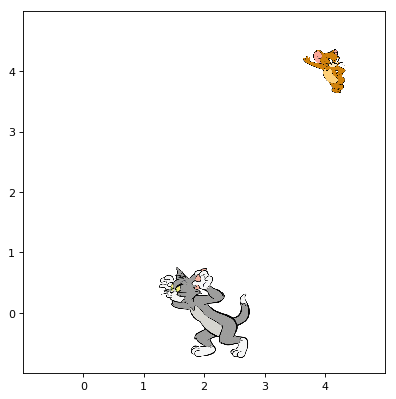

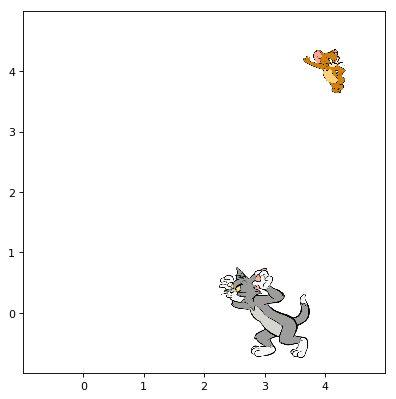

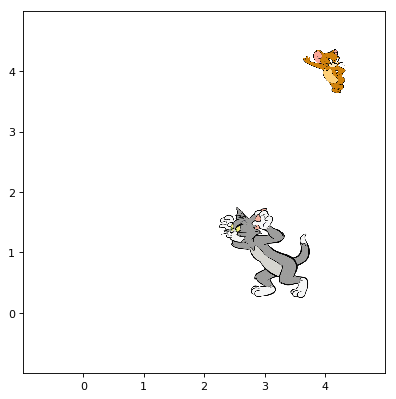

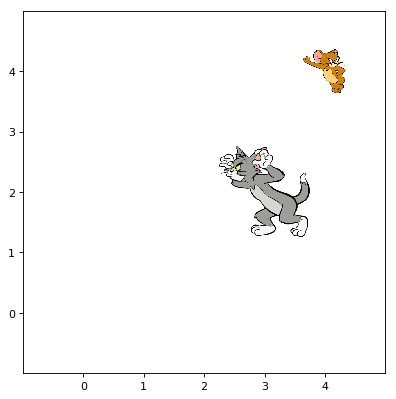

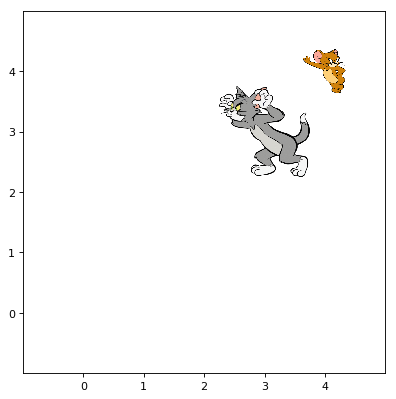

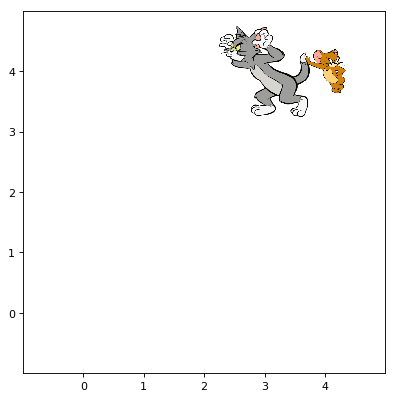

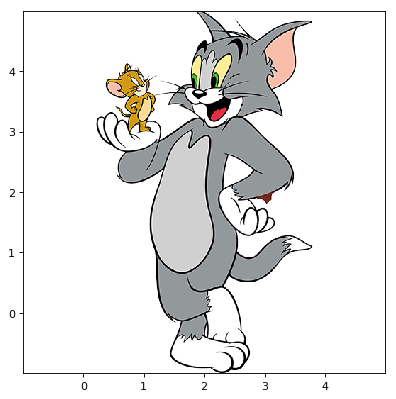

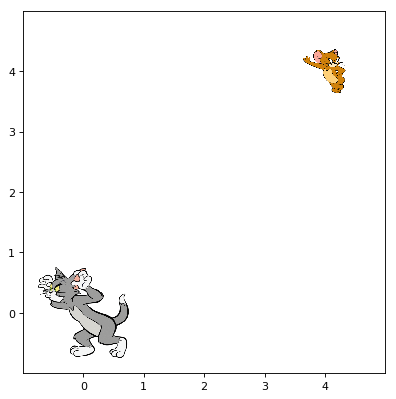

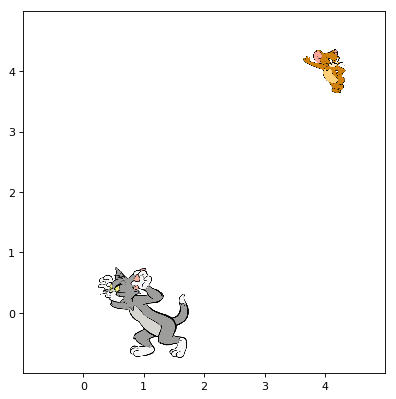

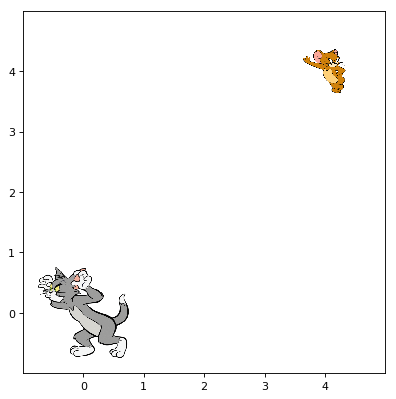

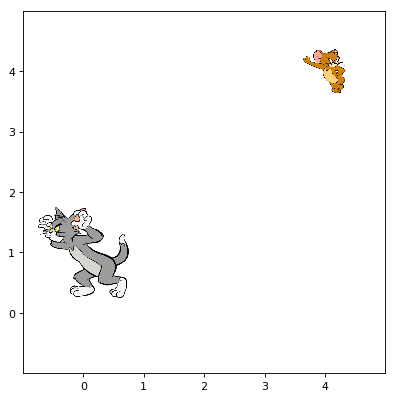

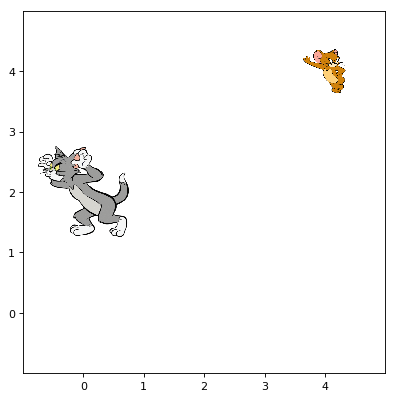

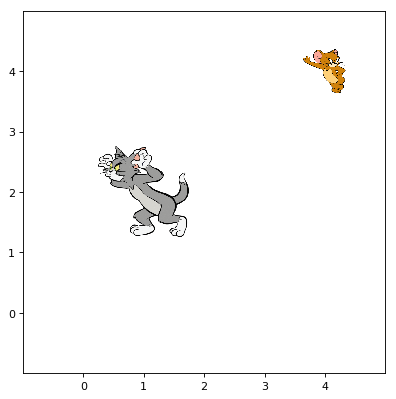

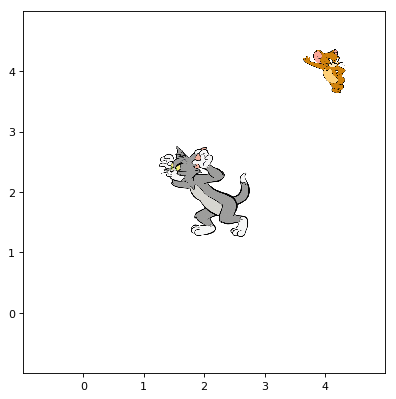

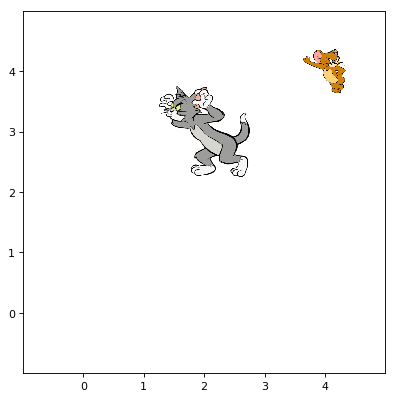

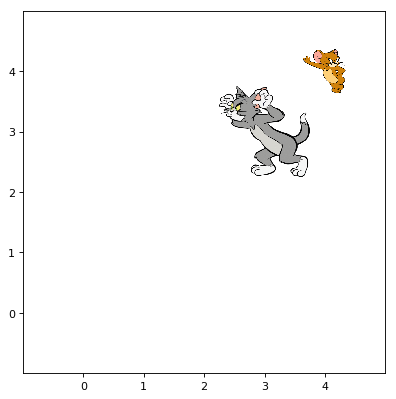

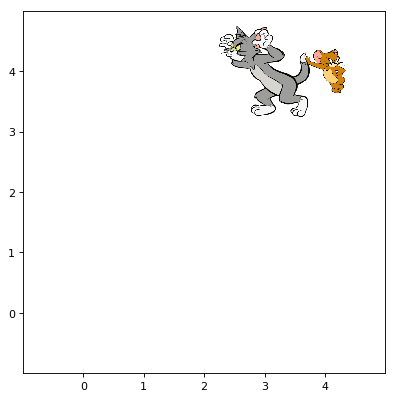

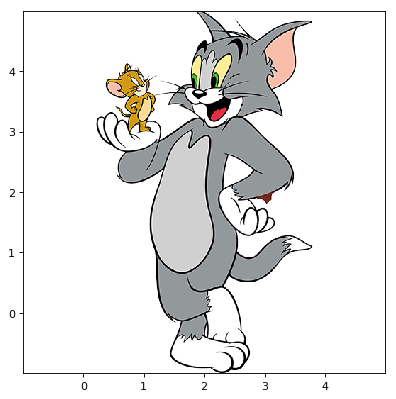

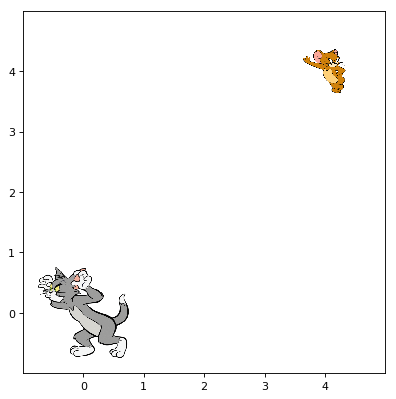

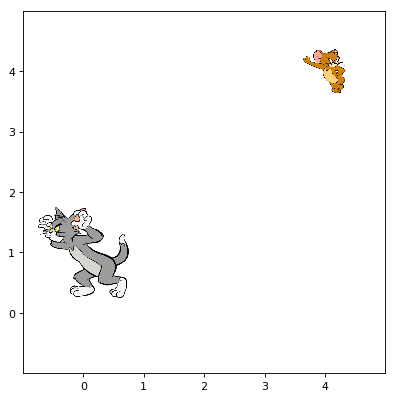

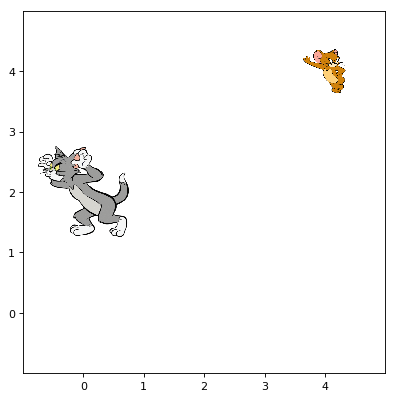

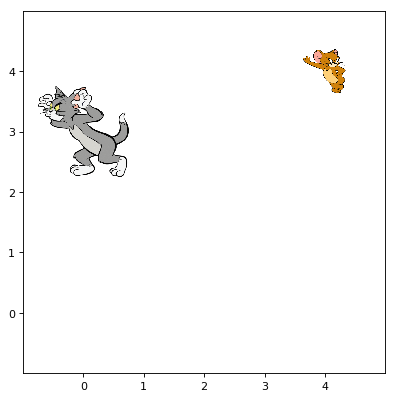

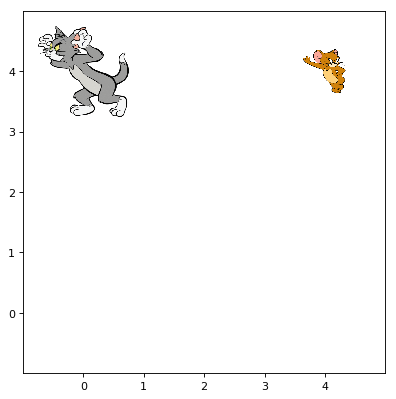

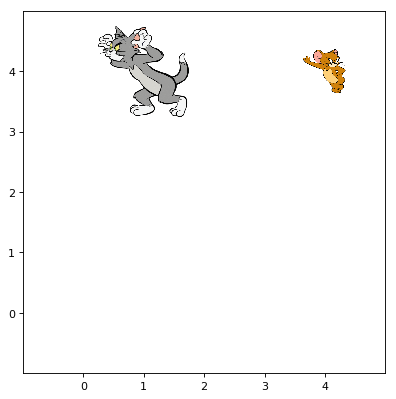

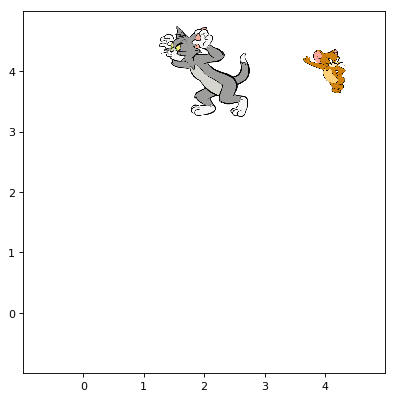

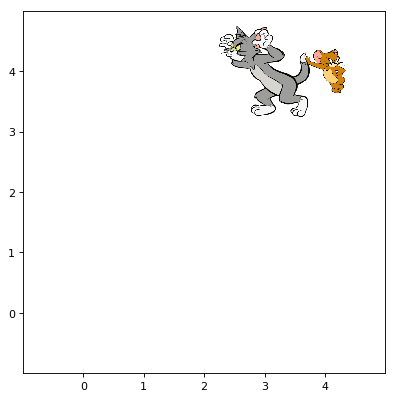

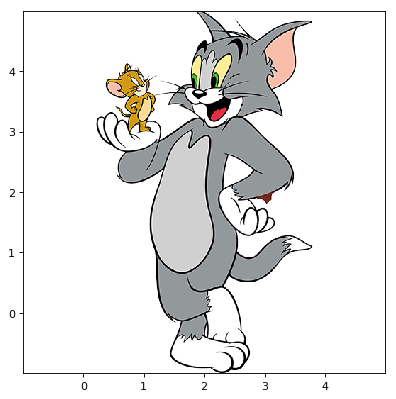

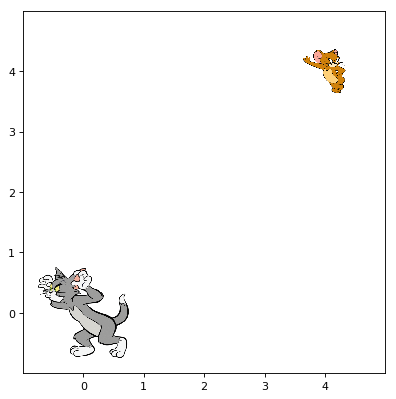

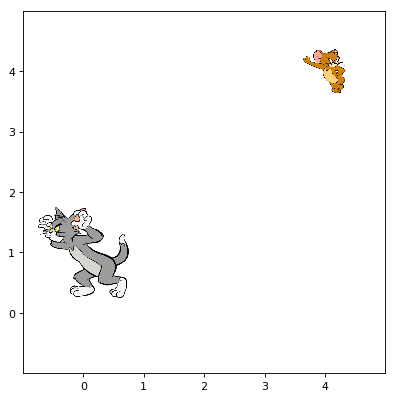

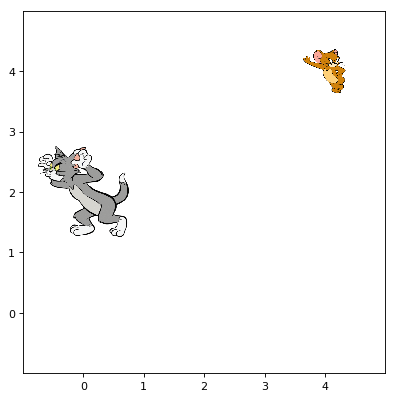

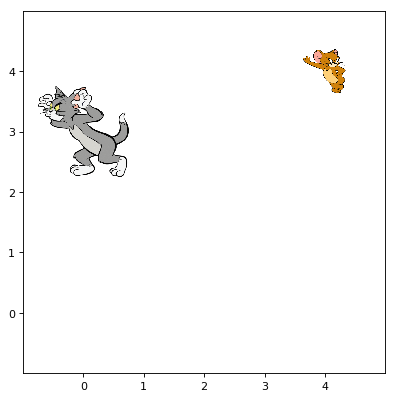

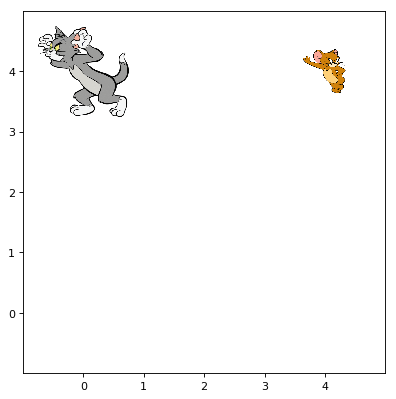

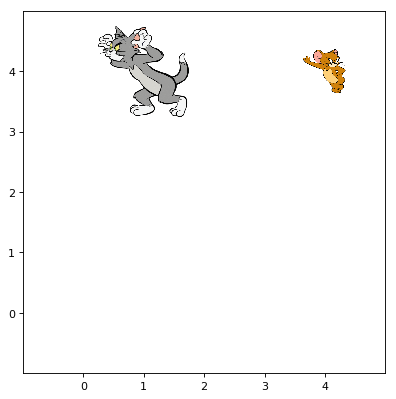

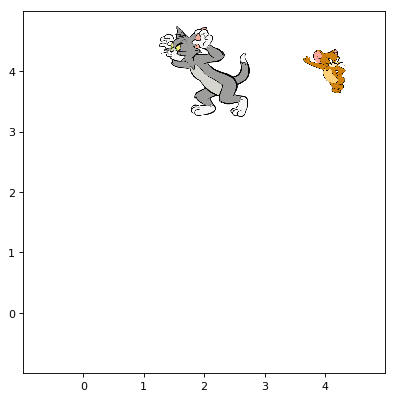

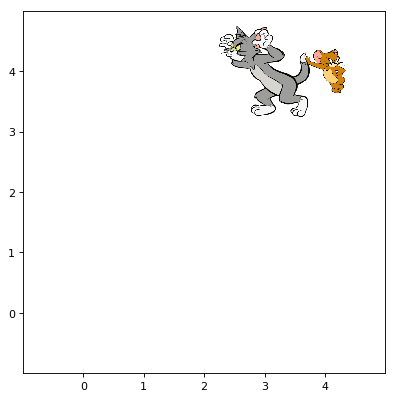

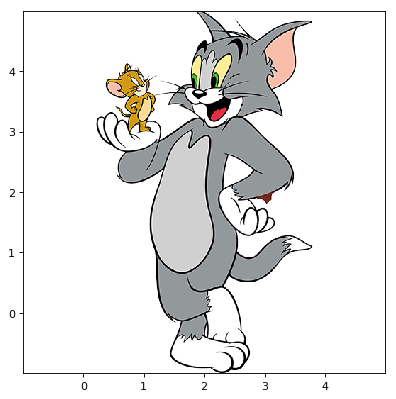

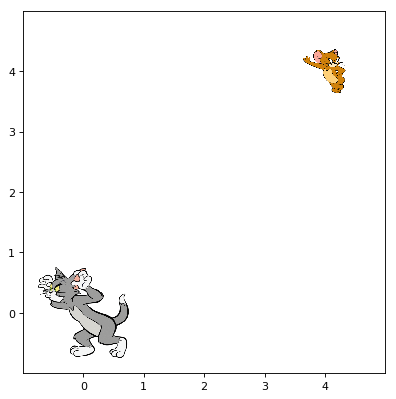

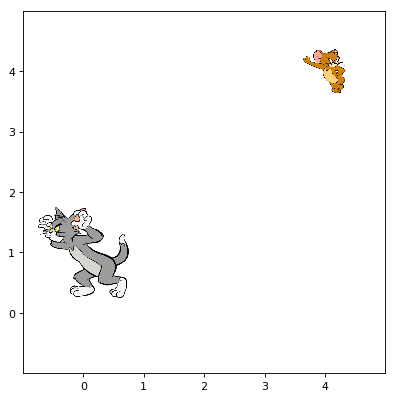

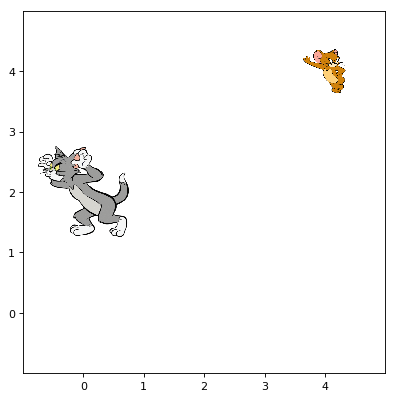

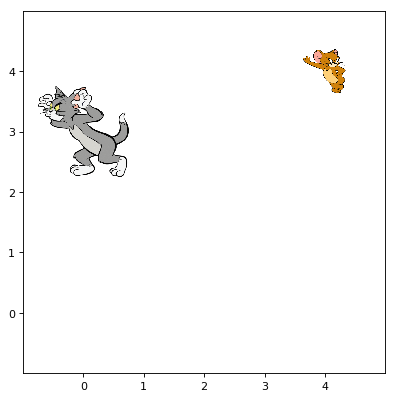

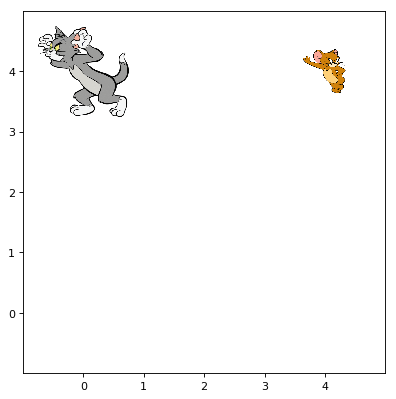

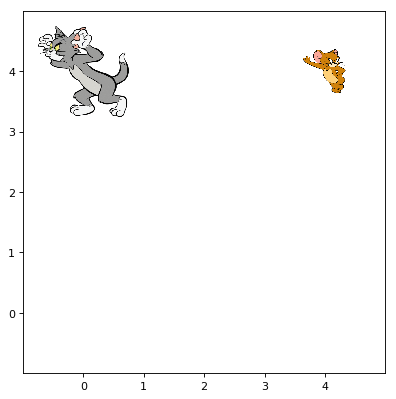

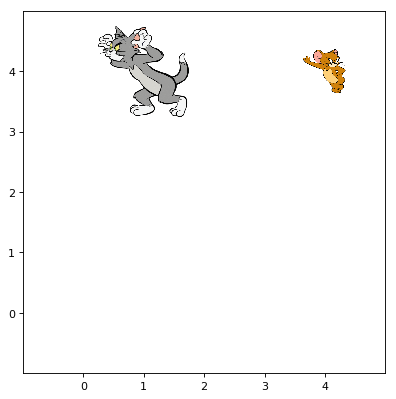

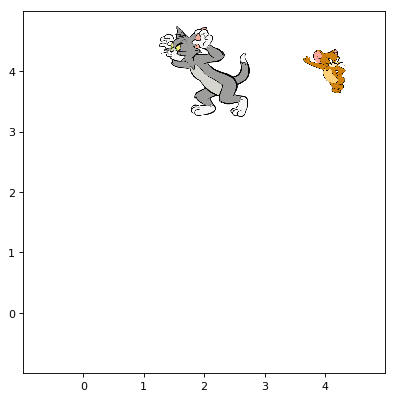

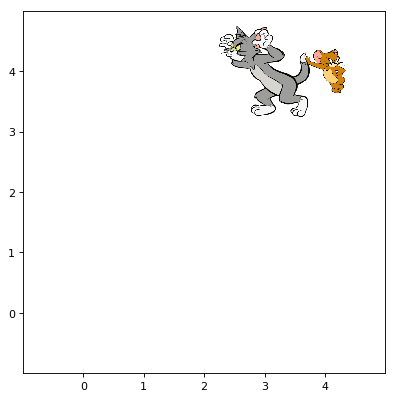

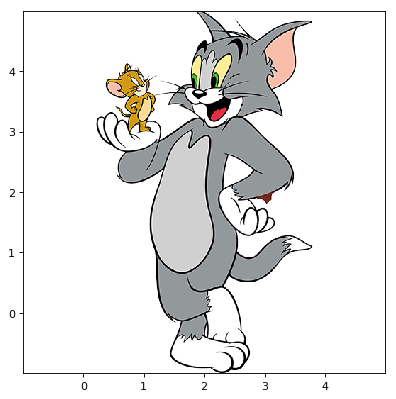

In [7]:
#-------------------- MAIN ----------------------------
print('Setting up environment')
env = Environment(5)

state_dim = 4
action_dim = 4 # left, right, up, down
print('Setting up agent')
MAX_EPSILON = 1 # the rate in which an agent randomly decides its action
MIN_EPSILON = 0.005 # min rate in which an agent randomly decides its action
LAMBDA = 0.00005      # speed of decay for epsilon
num_episodes = 10000 # number of games we want the agent to play

VERBOSE = False
agent = Agent(state_dim, action_dim, lamb=LAMBDA,
              max_epsilon=MAX_EPSILON, min_epsilon=MIN_EPSILON)
env.reset()
episode_rewards = []
epsilons = []
t0 = time.time()
frames = []

print('Running simulation')
for episode in range(num_episodes):
  s = env.reset() # Initial state
  if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
  R = 0
  while True: 
    a = agent.act(s, verbose=VERBOSE)

    s_, r, done = env.step(a)

    if done: # terminal state
        s_ = None

    agent.observe( (s, a, r, s_) )
    agent.replay()

    s = s_
    R += r
    
    if episode % 1000 == 0:
      fig = env.render()
      frames.append(fig)
    
    if VERBOSE:
      print("Action:", a)
      print("Reward:", r)

    if done:
      break
      
  epsilons.append(agent.epsilon)
  episode_rewards.append(R)
  
  if episode % 100 == 0:
    print('Episode {}'.format(episode))
    print('Time Elapsed: {0:.2f}s'.format(time.time() - t0))
    print('Epsilon {}'.format(epsilons[-1]))
    print('Last Episode Reward: {}'.format(R))
    print('Episode Reward Rolling Mean: {}'.format(np.mean(episode_rewards[:-100])))
    print('-'*10)

agent.brain.model.save("brain.h5")

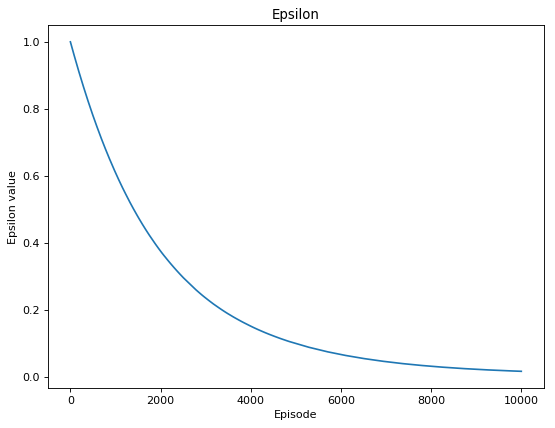

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Epsilon")
plt.xlabel("Episode")
plt.ylabel("Epsilon value")
plt.plot(epsilons)

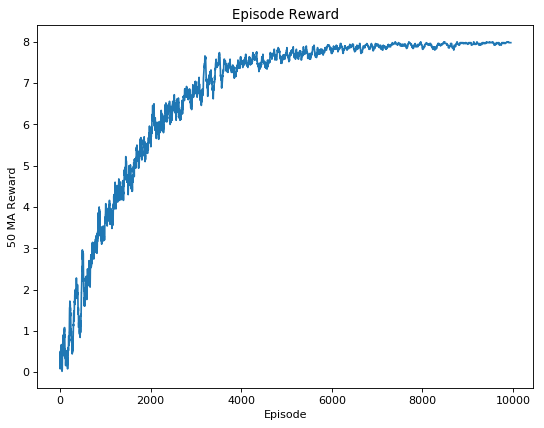

In [9]:
smoothing = 50
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("{} MA Reward".format(smoothing))
episode_ma = np.convolve(episode_rewards, 
                         np.ones((smoothing,))/smoothing, mode='valid')
plt.plot(episode_ma)

In [10]:
"""

To create animation, you need to install ffmpeg
These lines will install it in Google Colab
If you're running this notebook locally, you'll need to install
ffmpeg on your computer: 
https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg

Note: this lines will only work in Google Colab, do not run them locally.
"""

!apt install ffmpeg
!which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'

'apt' is not recognized as an internal or external command,
operable program or batch file.
'which' is not recognized as an internal or external command,
operable program or batch file.


RuntimeError: Requested MovieWriter (ffmpeg) not available

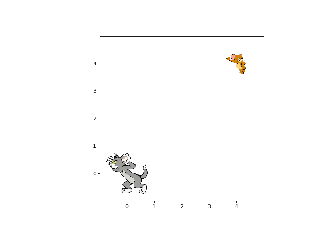

In [11]:
"""
This cell will compile the frames that should have been saved during training
into an animation.  This required ffmpeg to be installed.

If the main portion wasn't modified, this will have saved frames from every
1,000 episode.  In the animation, you should see it start off performing poorly,
but as it progresses it should perform optimally.
"""

fig, ax = plt.subplots()
plt.axis('off')
l = ax.imshow(frames[0])

def animate(i):
    l.set_data(frames[i])

Writer = animation.writers['ffmpeg']
writer = Writer(fps=12, metadata=dict(artist='Me'))
ani = animation.FuncAnimation(fig, animate, frames=len(frames))

ani.save('animation.mp4', writer=writer, dpi=220)
time.sleep(5) # let it process (only necessary in Colab)

In [ ]:
"""
If you're using Google Colab, you'll need to use the Google Colab
download function to download both the model you trained and the animation
you created.

If you're not using Google Colab, those files should be saved in the directory
where this notebook is located.
"""

# To Save Brain
files.download("brain.h5")

# To Save Animation
files.download('animation.mp4')